# Importing libraries

In [ ]:
! pip install medmnist keras_tuner -q

     |████████████████████████████████| 135 kB 6.6 MB/s 
     |████████████████████████████████| 87 kB 7.9 MB/s 
     |████████████████████████████████| 1.6 MB 43.0 MB/s 


In [ ]:
from sklearn.model_selection import KFold

import tensorflow as tf
import keras_tuner as kt

import medmnist
from medmnist import INFO
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Defining constants

In [ ]:
NUMFEATURES = 28 * 28 * 3 # = 2352
NUMCLASSES = 8

# Importing BloodMNIST

In [ ]:
info = INFO['bloodmnist']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor()
])

# raw data
train_dataset = DataClass(
    split='train', transform=data_transform, download=True)
val_dataset = DataClass(
    split='val', transform=data_transform, download=True)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


# Preprocessing data

In [ ]:
# converting images into arrays and normalizing
x_train = np.reshape(train_dataset.imgs, (-1, NUMFEATURES)) / 255
y_train = train_dataset.labels

x_val = np.reshape(val_dataset.imgs, (-1, NUMFEATURES)) / 255
y_val = val_dataset.labels

print(x_train.shape)
print(y_train.shape)

(11959, 2352)
(11959, 1)


# Building the network

In [ ]:
def build_model(layer_size, dropout_rate, learning_rate):

    # optimizer
    sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # building the model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(layer_size, 
                                    activation='relu', 
                                    input_shape=(NUMFEATURES,)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(NUMCLASSES, 
                                    activation='softmax'))

    model.compile(optimizer=sgd,
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    
    return model

# Hyperparameter tuning

In [ ]:
def hyperaprameter_tuning(hp):

  # defining hyperparameters to tune
  units = hp.Int("units", min_value=256, max_value=2048, sampling='log')
  learning_rate = hp.Float("learning_rate", min_value=1e-8, max_value=1e-1, sampling='log')
  dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.8, sampling='linear')
  
  model = build_model(units, dropout_rate, learning_rate)

  return model

tuner = kt.BayesianOptimization(hyperaprameter_tuning,
                     objective='val_accuracy',
                     max_trials=30,
                     overwrite=True)

# Cross-validating

In [ ]:
# early stopping to improve training efficiency
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner.search(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), callbacks=[stop_early], verbose=1)

Trial 725 Complete [00h 00m 42s]
val_accuracy: 0.726051390171051

Best val_accuracy So Far: 0.740070104598999
Total elapsed time: 00h 42m 34s


# Analysing the results

In [ ]:
tuner.results_summary()

Results summary
Results in ./results/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 768
dropout_rate: 0.24330848809077413
learning_rate: 0.004869104281661982
tuner/epochs: 250
tuner/initial_epoch: 84
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0696
Score: 0.740070104598999
Trial summary
Hyperparameters:
units: 1792
dropout_rate: 0.23480162525237575
learning_rate: 0.0041956670533739885
tuner/epochs: 250
tuner/initial_epoch: 84
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0705
Score: 0.735397219657898
Trial summary
Hyperparameters:
units: 1664
dropout_rate: 0.190589936069746
learning_rate: 0.006829523655422064
tuner/epochs: 250
tuner/initial_epoch: 84
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0593
Score: 0.7295560836791992
Trial summary
Hyperparameters:
units: 640
dropout_rate: 0.6767783647682492
learning_rate: 0.0032360023443108996
tuner/epochs: 250
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7272196412086487
Trial summary


Top parameters: 

best models id: 208, 251, 209 \\

model / learning_rate / units / dropout_rate / accuracy / loss \\
1 / 0.0081398 / 384.00 / 0.37825 / 0.74708 / 0.75613 \\
2 / 0.0076526 / 256.00 / 0.21952 / 0.68283 / 0.82437 \\
3 / 0.0073695 / 448.00 / 0.28526 / 0.73072 / 0.78310 \\

# Testing the model

In [ ]:
# building the best model
layer1_size   = 1504
layer2_size   = 1373
lamb          = 0
dropout_rate  = 0.7381460322970614

best_model = build_model(layer1_size, layer2_size, lamb, dropout_rate)

# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))

stop_early = stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
best_model.fit(x_all, y_all, batch_size=32, epochs=50)

In [ ]:
# building the best model
layer_size = best_hps[0].get("units")
dropout_rate = best_hps[0].get("dropout_rate")
learning_rate = best_hps[0].get("learning_rate")

best_model = build_model(layer_size, dropout_rate, learning_rate)

# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_val))
y_all = np.concatenate((y_train, y_val))

stop_early = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
best_model.fit(x_all, y_all, batch_size=1024, epochs=500)

Epoch 1/500
14/14 [==============================] - 0s 9ms/step - loss: 2.0265 - accuracy: 0.2245
Epoch 2/500
14/14 [==============================] - 0s 9ms/step - loss: 1.8717 - accuracy: 0.3061
Epoch 3/500
14/14 [==============================] - 0s 8ms/step - loss: 1.8019 - accuracy: 0.3421
Epoch 4/500
14/14 [==============================] - 0s 8ms/step - loss: 1.7325 - accuracy: 0.3643
Epoch 5/500
14/14 [==============================] - 0s 8ms/step - loss: 1.6829 - accuracy: 0.3826
Epoch 6/500
14/14 [==============================] - 0s 8ms/step - loss: 1.6373 - accuracy: 0.4047
Epoch 7/500
14/14 [==============================] - 0s 8ms/step - loss: 1.5990 - accuracy: 0.4222
Epoch 8/500
14/14 [==============================] - 0s 8ms/step - loss: 1.5535 - accuracy: 0.4438
Epoch 9/500
14/14 [==============================] - 0s 7ms/step - loss: 1.5226 - accuracy: 0.4507
Epoch 10/500
14/14 [==============================] - 0s 7ms/step - loss: 1.5004 - accuracy: 0.4591
Epoch 11/

In [ ]:
# obtaining the test dataset
test_dataset = DataClass(
    split='test', transform=data_transform, download=True)

x_test = np.reshape(test_dataset.imgs, (-1, NUMFEATURES)) / 255
y_test = test_dataset.labels

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


#Results

In [ ]:
# metrics
print(best_model.evaluate(x_test, y_test))
print(best_model.metrics_names)

107/107 [==============================] - 0s 3ms/step - loss: 0.6035 - accuracy: 0.7998
[0.6034544110298157, 0.7997661232948303]
['loss', 'accuracy']


 31/107 [=======>......................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


107/107 [==============================] - 0s 2ms/step


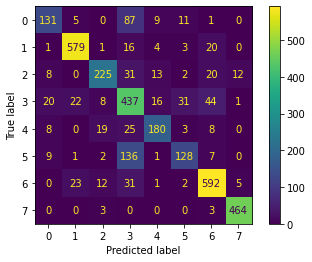

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# confusion matrix
class estimator:
  _estimator_type = ''
  classes_=[]
  def __init__(self, model, classes):
    self.model = model
    self._estimator_type = 'classifier'
    self.classes_ = classes
  def predict(self, X):
    y_prob= self.model.predict(X)
    y_pred = y_prob.argmax(axis=1)
    return y_pred

labels=y_test
classifier = estimator(best_model, classes=labels)
plot_confusion_matrix(estimator=classifier, X=x_test, y_true=y_test)